In [1]:
import sys
sys.path.insert(1, '/ai/gno/CODE/GPNO/')

import yaml
import torch
import matplotlib.pyplot as plt
import os.path as osp

from trainers.builder import *
from datasets import ERA5Dataset

from matplotlib.patches import Ellipse
import numpy as np

from tqdm import tqdm

In [2]:
def vis_gaussian(mu, sigma, weight, ax, factor=1):
    mu = mu.squeeze(0)
    sigma = sigma.squeeze(0)

    mu = mu.cpu().detach().numpy()
    sigma = sigma.cpu().detach().numpy()
    weight = weight.cpu().detach().numpy()
    N, G, d = mu.shape

    sample_idx = np.arange(N)
    sample_idx = sample_idx[::factor]

    for n in tqdm(sample_idx):
        # normalize weights
        w_n = np.abs(weight) + 1e-6
        w_n = np.ones_like(w_n)
        w_n = w_n / np.sum(w_n)  # (G,)

        mu_n = mu[n]  # (G,2)
        sigma_n = sigma[n]  # (G,2)

        # 融合中心
        mu_fused = (w_n[:,None] * mu_n).sum(axis=0)  # (2,)

        # 融合尺度
        sigma_fused = (w_n[:,None] * (sigma_n**2 + (mu_n - mu_fused)**2)).sum(axis=0)  # (2,)

        width = np.sqrt(sigma_fused[0]) * 0.5
        height = np.sqrt(sigma_fused[1]) * 0.5
        angle = 0

        mu_fused[0] = 180 * mu_fused[0] - 90
        mu_fused[1] = 360 * mu_fused[1]

        ellipse = Ellipse(
            xy=(mu_fused[1], mu_fused[0]),
            width=width,
            height=height,
            angle=angle,
            edgecolor='red',
            facecolor='none',
            lw=1,
            alpha=0.8
        )
        ax.add_patch(ellipse)

    plt.xlabel('x')
    plt.ylabel('y')
    plt.title('Predicted u(x) with Gaussian Ellipses')
    # plt.axis('equal')
    plt.show()

In [3]:
era5_set = ERA5Dataset(
    data_path="/ai/gno/DATA/era5/20d/era_721_1440.pt",
    raw_resolution=[721, 1440, 24],
    sample_resolution=[721, 1440, 24],
    eval_resolution=[721, 1440, 24],
    in_t=1,
    out_t=1,
    duration_t=23,
    train_day=12,
    valid_day=4,
    test_day=4,
    train_batchsize=16,
    eval_batchsize=16,
    normalize=True,
    normalizer_type='PGN',
    prop='temp',
    # prop='wind_u',
    sub=0.1,
)

Loading processed data from  /ai/gno/DATA/era5/20d/era_721_1440_temp_processed.pt


In [4]:
# gs_dir = '/ai/gno/CODE/GPNO/logs/ERA5/05_06/GaussianField_22_58_41' # temp
gs_dir = '/ai/gno/CODE/GPNO/logs/ERA5/05_07/GaussianField_23_15_39'
# gs_dir = '/ai/gno/CODE/GPNO/logs/ERA5/05_07/GaussianField_09_40_04' # wind_u
# gs_dir = '/ai/gno/CODE/GPNO/logs/ERA5/05_07/GaussianField_09_40_30' # wind_v
# gs_dir = '/ai/gno/CODE/GPNO/logs/ERA5/05_07/GaussianField_09_40_52' # vel
gs_args_path = osp.join(gs_dir, 'config.yaml')
gs_path = osp.join(gs_dir, 'best_model.pth')
gs_args = yaml.load(open(gs_args_path, 'r'), Loader=yaml.FullLoader)
gs = GSTrainer(gs_args).build_model(gs_args)
gs.load_state_dict(torch.load(gs_path))
gs.cuda()
gs.eval()

GaussianField(
  (encoder): GaussianEncoder(
    (mlp_mu): Sequential(
      (0): Linear(in_features=3, out_features=64, bias=True)
      (1): ReLU()
      (2): Linear(in_features=64, out_features=32, bias=True)
    )
    (mlp_sigma): Sequential(
      (0): Linear(in_features=3, out_features=64, bias=True)
      (1): ReLU()
      (2): Linear(in_features=64, out_features=32, bias=True)
      (3): Softplus(beta=1.0, threshold=20.0)
    )
    (softplus): Softplus(beta=1.0, threshold=20.0)
  )
  (decoder): GaussianDecoder(
    (mlp): Sequential(
      (0): Linear(in_features=16, out_features=64, bias=True)
      (1): ReLU()
      (2): Linear(in_features=64, out_features=64, bias=True)
      (3): ReLU()
      (4): Linear(in_features=64, out_features=1, bias=True)
    )
  )
)

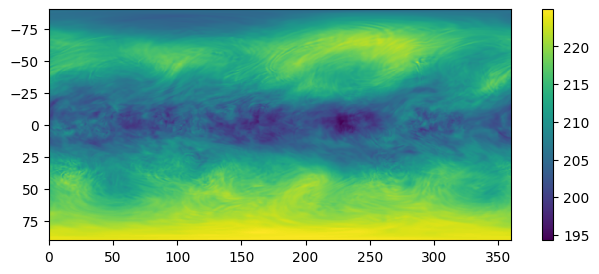

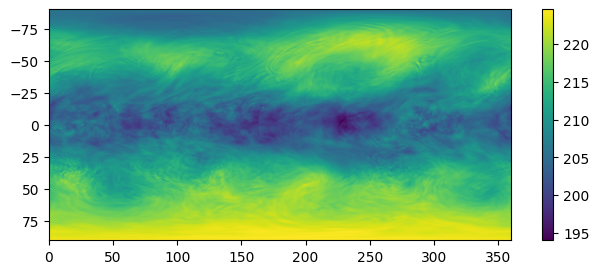

In [5]:
# vis_x = ns_set.test_dataset.x[128:129]
# vis_y = ns_set.test_dataset.y[128:129]

# vis_x = ns_set.test_dataset.x[38:39]
# vis_y = ns_set.test_dataset.y[38:39]

vis_x = era5_set.test_dataset.x[10:11]
vis_y = era5_set.test_dataset.y[10:11]

# plt.figure(dpi=1000)

# vis_x = vis_x.transpose(1, 2).reshape(vis_x.shape[0], 1440, 721, vis_x.shape[-1])
# vis_y = vis_y.transpose(1, 2).reshape(vis_y.shape[0], 1440, 721, vis_y.shape[-1])

x = era5_set.test_dataset.x_normalizer.decode(vis_x[..., -1:])
fig, ax = plt.subplots(figsize=(8,3))
heatmap = ax.imshow(x.reshape(721, 1440), cmap='viridis', interpolation='nearest', origin='lower', extent=[0, 360, 90, -90])
# plt.axis("off")
plt.colorbar(heatmap)
plt.show()

y = era5_set.test_dataset.y_normalizer.decode(vis_y)
fig, ax = plt.subplots(figsize=(8,3))
heatmap = ax.imshow(y.reshape(721, 1440), cmap='viridis', interpolation='nearest', origin='lower', extent=[0, 360, 90, -90])
# plt.axis("off")
plt.colorbar(heatmap)
plt.show()

vis_y = torch.cat([vis_x[..., :2], vis_y], dim=-1)

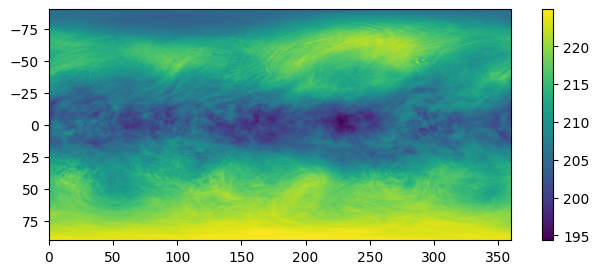

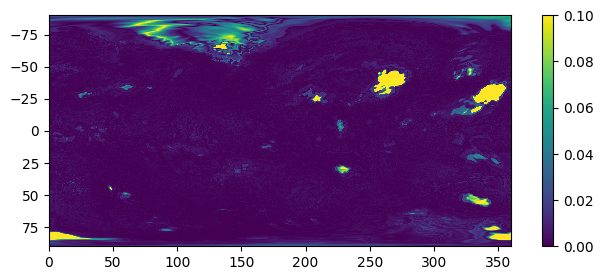

100%|██████████| 10383/10383 [00:25<00:00, 408.21it/s]


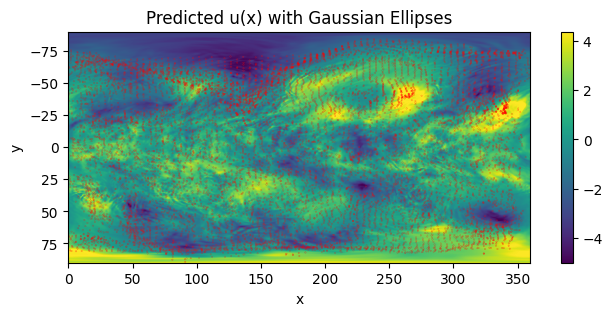

In [6]:
pred_x = gs(vis_x.cuda()).view(1, -1, 1)
pred_x = era5_set.test_dataset.x_normalizer.decode(pred_x)
pred_x = pred_x.cpu().detach().reshape(721, 1440)
# plt.figure(dpi=1000)
fig, ax = plt.subplots(figsize=(8,3))

heatmap = ax.imshow(pred_x, cmap='viridis', interpolation='nearest', origin='lower', extent=[0, 360, 90, -90])
# plt.axis("off")
plt.colorbar(heatmap)
plt.show()

x = era5_set.test_dataset.x_normalizer.decode(vis_x[..., -1:])
error = torch.abs(pred_x.reshape(721, 1440) - x.reshape(721, 1440))
# plt.figure(dpi=1000)
fig, ax = plt.subplots(figsize=(8,3))
heatmap = ax.imshow(error, cmap='viridis', interpolation='nearest', vmin=0, vmax=0.1, origin='lower', extent=[0, 360, 90, -90])
# plt.axis("off")
plt.colorbar(heatmap)
plt.show()

pred_x = gs(vis_x.cuda()).cpu().detach().reshape(721, 1440)
mu, sigma, weight = gs.encode_gaussian(vis_x.cuda())
fig, ax = plt.subplots(figsize=(8,3))
heatmap = ax.imshow(pred_x, cmap='viridis', interpolation='nearest', origin='lower', extent=[0, 360, 90, -90])
plt.colorbar(heatmap)
vis_gaussian(mu, sigma, weight, ax, factor=100)

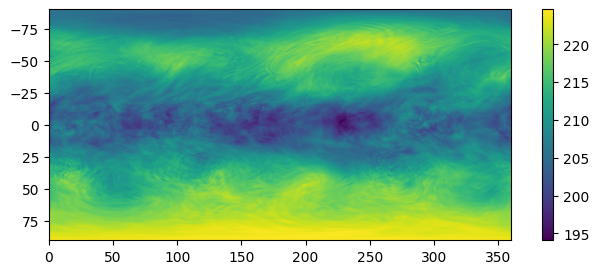

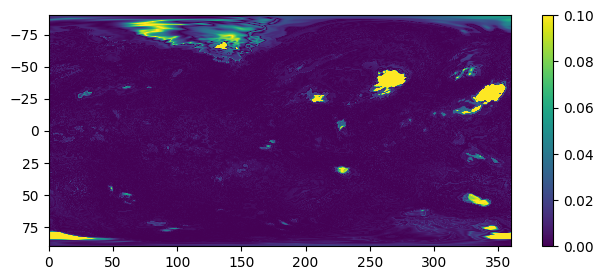

100%|██████████| 10383/10383 [00:25<00:00, 405.84it/s]


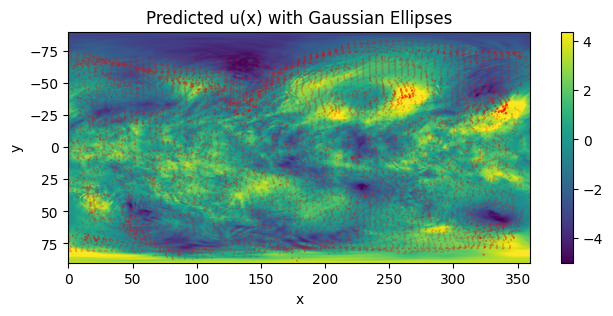

In [7]:
pred_y = gs(vis_y.cuda()).view(1, -1, 1)
pred_y = era5_set.test_dataset.y_normalizer.decode(pred_y)
pred_y = pred_y.cpu().detach().reshape(721, 1440)
# plt.figure(dpi=1000)
fig, ax = plt.subplots(figsize=(8,3))

heatmap = ax.imshow(pred_y, cmap='viridis', interpolation='nearest', origin='lower', extent=[0, 360, 90, -90])
# plt.axis("off")
plt.colorbar(heatmap)
plt.show()

y = era5_set.test_dataset.y_normalizer.decode(vis_y[..., -1:])
error = torch.abs(pred_y.reshape(721, 1440) - y.reshape(721, 1440))
# plt.figure(dpi=1000)
fig, ax = plt.subplots(figsize=(8,3))
heatmap = ax.imshow(error, cmap='viridis', interpolation='nearest', vmin=0, vmax=0.1, origin='lower', extent=[0, 360, 90, -90])
# plt.axis("off")
plt.colorbar(heatmap)
plt.show()

pred_y = gs(vis_y.cuda()).cpu().detach().reshape(721, 1440)
mu, sigma, weight = gs.encode_gaussian(vis_y.cuda())
fig, ax = plt.subplots(figsize=(8,3))
heatmap = ax.imshow(pred_y, cmap='viridis', interpolation='nearest', origin='lower', extent=[0, 360, 90, -90])
plt.colorbar(heatmap)
vis_gaussian(mu, sigma, weight, ax, factor=100)